In [5]:
!git clone https://github.com/ShubhamMishra1611/CNN_DOA.git

Cloning into 'CNN_DOA'...
remote: Enumerating objects: 55757, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 55757 (delta 17), reused 17 (delta 15), pack-reused 55734
Receiving objects: 100% (55757/55757), 370.48 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (1262/1262), done.
Updating files: 100% (53925/53925), done.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# !python /content/main.py

# Step by step training

In [3]:
from extract_audio import extractAudiodata
from utils import sorted_nicely
from calcs import featureExtractor2, computeSI
from model import get_model

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import shuffle
import random
import sklearn
import re
plt.style.use('seaborn')


# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

from tensorflow import keras

<ipython-input-4-cbd0ef62e3d8>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
%cd /content/CNN_DOA/DATASETS/MATLAB_TEST10

/content/CNN_DOA/DATASETS/MATLAB_TEST10


In [6]:
# Get list of audio files in the train dataset
audiofiles_train = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_train = sorted_nicely(audiofiles_train)

sr = 16000
duration = 0.5

# Extract audio and labels
trainAudioMatrix, sourceIDs, labels30, labels10 = extractAudiodata(audiofiles_train, sr*duration)

# Init gamma
datapointsNum = trainAudioMatrix.shape[-1]
Gamma_container = np.zeros([datapointsNum, 14, 511, 10])

# Extract SI features
for i in tqdm(range(0, datapointsNum)):
  Gamma_container[i,:,:,:] = featureExtractor2(trainAudioMatrix[:,:,i])

# Casting labels as integers
intLabels10 = np.array(labels10, dtype='uint8')
intLabels30 = np.array(labels30, dtype='uint8')

100%|██████████| 360/360 [00:02<00:00, 148.85it/s]


In [7]:
# Get list of audio files in the validation dataset
audiofiles_val = [str(file) for file in Path().glob('SA*.wav')]
audiofiles_val = sorted_nicely(audiofiles_val)

sr = 16000
duration = 0.5

# Extract audio and labels
valAudioMatrix, sourceIDs, valLabels30, valLabels10 = extractAudiodata(audiofiles_val, sr*duration)

# Init gamma
datapointsNum = valAudioMatrix.shape[-1]
Gamma_container_val = np.zeros([datapointsNum, 14, 511, 10])

# Extract SI features
for i in tqdm(range(0, datapointsNum)):
  Gamma_container_val[i,:,:,:] = featureExtractor2(valAudioMatrix[:,:,i])

# Casting labels as integers
intValLabels10 = np.array(valLabels10, dtype='uint8')
intValLabels30 = np.array(valLabels30, dtype='uint8')

100%|██████████| 360/360 [00:02<00:00, 158.16it/s]


In [8]:
from model3 import get_model
model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 511, 10)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 12, 509, 64)          5824      ['input_1[0][0]']             
                                                                                                  
 bn1 (BatchNormalization)    (None, 12, 509, 64)          256       ['conv1[0][0]']               
                                                                                                  
 conv2 (Conv2D)              (None, 10, 507, 64)          36928     ['bn1[0][0]']                 
                                                                                              

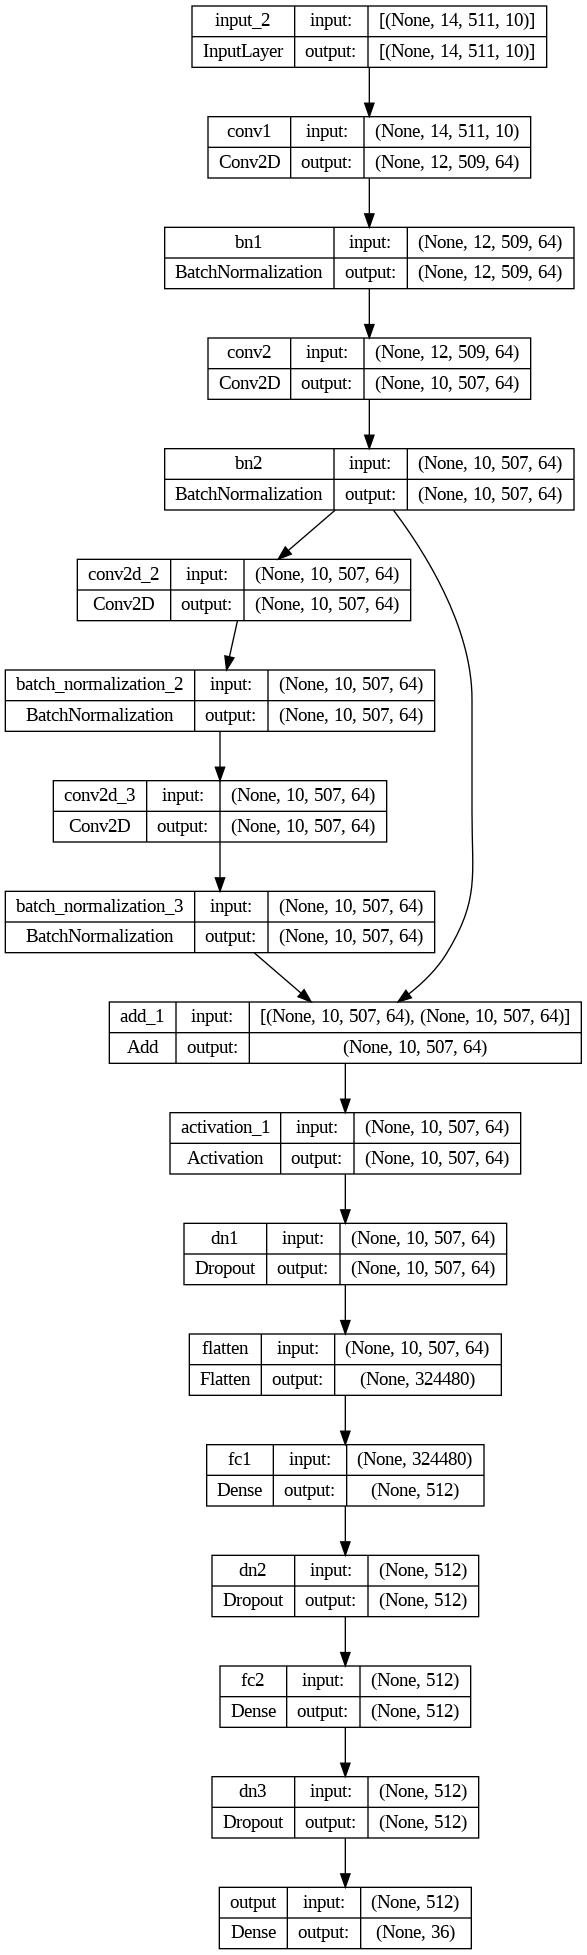

In [9]:
from tensorflow.keras.utils import plot_model

# Visualize the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [10]:
# Compile
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

In [11]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


callbacks = [
  model_checkpoint_callback,
  tf.keras.callbacks.EarlyStopping(patience=25, monitor='accuracy', mode='max'),
]

In [12]:
# Shuffling the features
(Gamma_container, intLabels10) = shuffle(Gamma_container, intLabels10)
(Gamma_container_val, intValLabels10) = shuffle(Gamma_container_val, intValLabels10)

In [13]:
history = model.fit(Gamma_container, intLabels10, validation_data=(Gamma_container_val, intValLabels10),  epochs=400, callbacks=callbacks)

Epoch 1/400
12/12 [==============================] - 26s 2s/step - loss: 4.4728 - accuracy: 0.0361 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 2/400
12/12 [==============================] - 2s 125ms/step - loss: 3.9984 - accuracy: 0.0333 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 3/400
12/12 [==============================] - 2s 133ms/step - loss: 3.7314 - accuracy: 0.0583 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 4/400
12/12 [==============================] - 2s 135ms/step - loss: 3.6942 - accuracy: 0.0722 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 5/400
12/12 [==============================] - 2s 129ms/step - loss: 3.5771 - accuracy: 0.0528 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 6/400
12/12 [==============================] - 2s 136ms/step - loss: 3.5228 - accuracy: 0.0972 - val_loss: 3.5835 - val_accuracy: 0.0278
Epoch 7/400
12/12 [==============================] - 23s 2s/step - loss: 3.4187 - accuracy: 0.0889 - val_loss: 3.5835 - val_accuracy: 0.0333
Epo

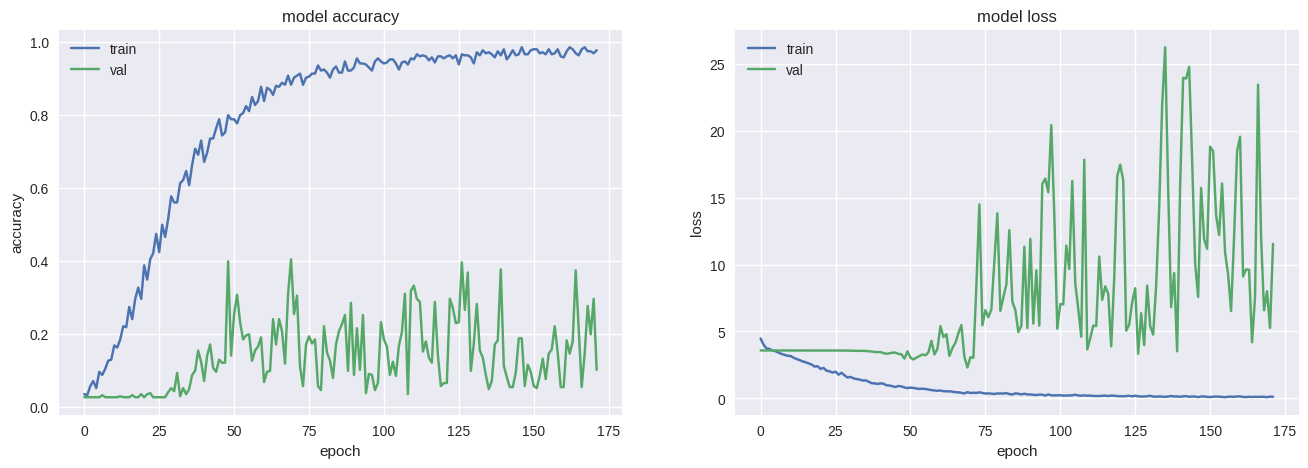

In [14]:
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# plt.subplot(1,2,2)
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Save the figure
plt.savefig('training_plot_model_res_10.png')
plt.show()


In [15]:
# model.save('/content/model')

In [16]:
# !zip -r '/content/model2_attention.zip' '/content/model'